In [31]:
# Imports
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from tqdm import tqdm
from itertools import product
from numpy.linalg import LinAlgError
from sklearn.metrics import mean_squared_error

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.api import VARMAX
from sklearn.metrics import mean_absolute_error

from helpers import plot_correlogram

In [32]:
# Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.Date = pd.to_datetime(ohlcv.Date)
ohlcv.columns = list(map(str.lower, ohlcv.columns))

In [33]:
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv

open        high         low       close     volume
ticker date                                                                 
MMM    2021-08-27  196.000000  196.660004  194.119995  195.050003  2146500.0
       2021-08-26  194.190002  195.389999  193.660004  195.320007  1457300.0
       2021-08-25  194.520004  195.050003  192.720001  194.339996  1612600.0
       2021-08-24  194.820007  196.100006  194.339996  194.750000  1392400.0
       2021-08-23  195.000000  196.240005  193.679993  194.679993  1974300.0
...                       ...         ...         ...         ...        ...
ZTS    2014-01-08   29.972334   30.331511   29.783295   30.000690  3965900.0
       2014-01-07   30.426026   30.671780   30.199180   30.340958  2338200.0
       2014-01-06   30.530009   30.936446   30.104669   30.227545  2763200.0
       2014-01-03   30.567808   30.719041   30.265344   30.293699  2524900.0
       2014-01-02   30.747394   30.870272   30.350412   30.586712  2576100.0

[953389 rows x 5 columns]

### Decomposition

In [34]:
# Selecting stock and resampling to fill gaps
symbol = "FB"
x = ohlcv.loc[symbol].close.sort_index().resample('d').first()
x = x.loc['2014-01-01':'2020-12-31']

In [35]:
# Filling gaps with previous values
x = x.fillna(method='ffill')
x

date
2014-01-02     54.709999
2014-01-03     54.560001
2014-01-04     54.560001
2014-01-05     54.560001
2014-01-06     57.200001
                 ...    
2020-12-27    267.399994
2020-12-28    277.000000
2020-12-29    276.779999
2020-12-30    271.869995
2020-12-31    273.160004
Freq: D, Name: close, Length: 2556, dtype: float64

In [36]:
# Decomposition
components = tsa.seasonal_decompose(x, model='additive')

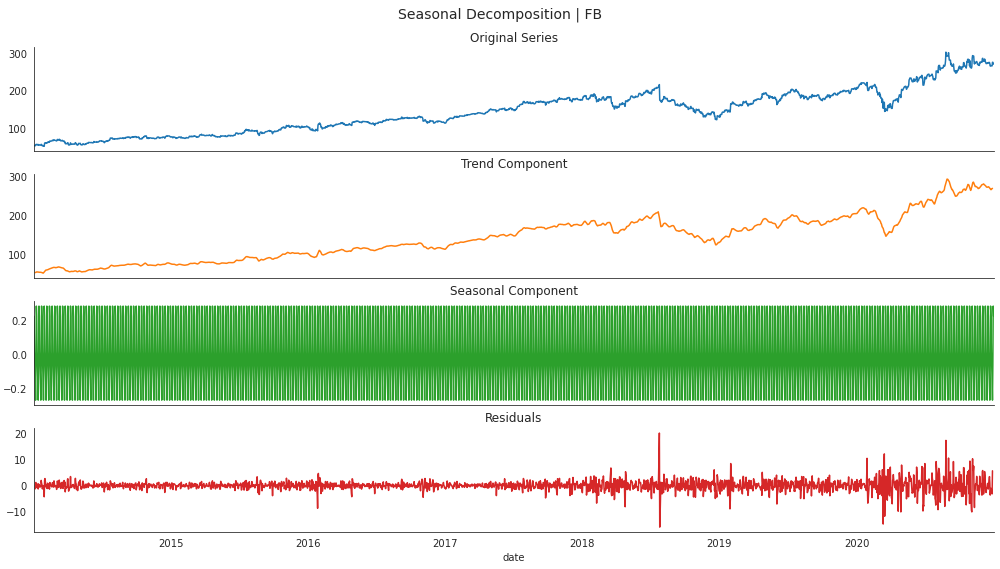

In [37]:
# Plotting
ts = (x.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle(f'Seasonal Decomposition | {symbol}', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [38]:
# Calculating log and log-diff for stationarity
x = ohlcv.loc[symbol].close.sort_index()
x = x.loc['2014-01-01':'2020-12-31']
x_log = np.log(x)
x_log_diff = x_log.diff(21).dropna()

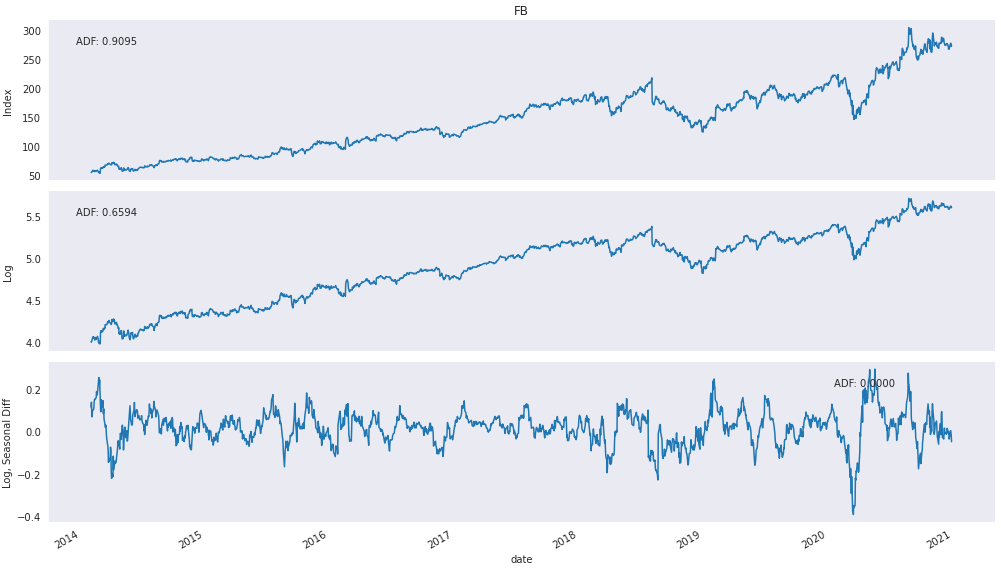

In [40]:
# Plotting
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

    x.plot(ax=axes[0],
                               title=f'{symbol}')
    axes[0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(x)[1]:.4f}',
                    transform=axes[0].transAxes)
    axes[0].set_ylabel('Index')

    x_log.plot(ax=axes[1],
                                   sharex=axes[0])
    axes[1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(x_log.dropna())[1]:.4f}',
                    transform=axes[1].transAxes)
    axes[1].set_ylabel('Log')

    x_log_diff.plot(ax=axes[2],
                                        sharex=axes[0])
    axes[2].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(x_log_diff.dropna())[1]:.4f}',
                    transform=axes[2].transAxes)
    axes[2].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

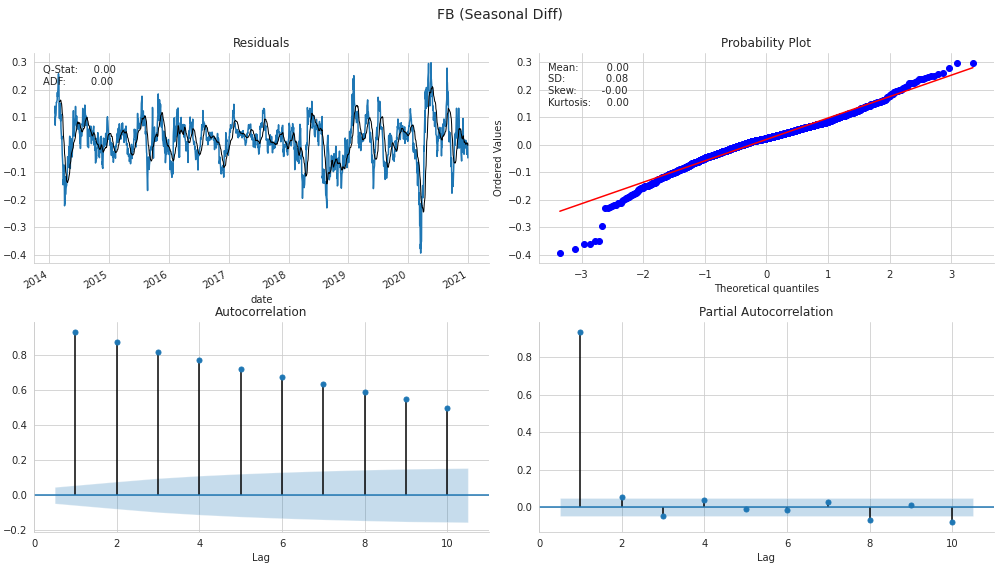

In [41]:
# Plotting correlogram for autocorrelation
plot_correlogram(x_log_diff, title=f'{symbol} (Seasonal Diff)')

### ARMA

In [75]:
# Training and cross-validating model to find best lag and window
train_size = 1008
results = {}
y_true = x_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(x_log_diff)):
            train_set = x_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [53]:
# Evaluating cross-validation results
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [54]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE          AIC          BIC  convergence  stationarity
p q                                                               
4 3  0.031613 -4484.944780 -4440.703269          2.0           0.0
3 2  0.031711 -4468.639596 -4434.229532          1.0           0.0
  0  0.031811 -4446.209216 -4421.630599          0.0           0.0
2 1  0.031814 -4446.209775 -4421.631157          0.0           2.0
4 2  0.031820 -4463.234840 -4423.909053          2.0           0.0

In [55]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE          AIC          BIC  convergence  stationarity
p q                                                               
4 3  0.031613 -4484.944780 -4440.703269          2.0           0.0
  4  0.040659 -4488.686522 -4439.529288          3.0          91.0
3 4  0.088254 -4482.523701 -4438.282190          0.0         125.0
  2  0.031711 -4468.639596 -4434.229532          1.0           0.0
1 0  0.032107 -4445.105233 -4430.358063          0.0           0.0

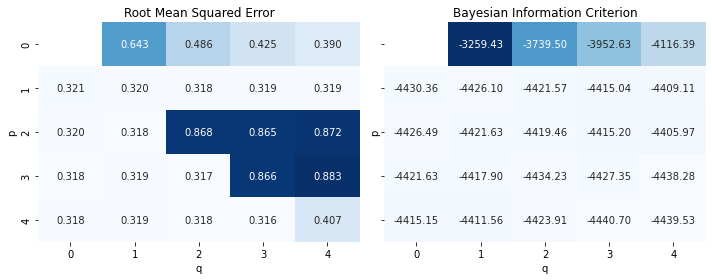

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<0.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [58]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
4  3    1.0
3  2    3.0
2  1    7.0
3  0    7.0
4  2    7.0
dtype: float64

In [59]:
# Selecting best pair of lag and window 
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [60]:
print(best_p, best_q)

4 3


In [61]:
# ARMA Summary for close predictions
best_arma_model = tsa.ARMA(endog=x_log_diff, order=(best_p, best_q)).fit()
print(best_arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1742
Model:                     ARMA(4, 3)   Log Likelihood                3802.386
Method:                       css-mle   S.D. of innovations              0.027
Date:                Sat, 04 Sep 2021   AIC                          -7586.772
Time:                        19:40:42   BIC                          -7537.606
Sample:                             0   HQIC                         -7568.593
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0185      0.004      4.473      0.000       0.010       0.027
ar.L1.close     0.5150      0.015     34.486      0.000       0.486       0.544
ar.L2.close     0.8890      0.016     54.799    

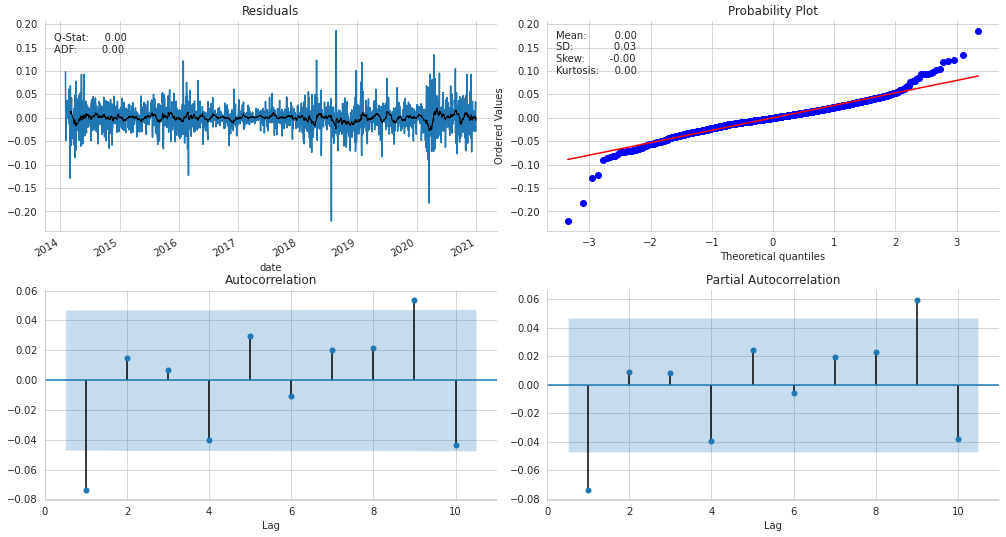

In [62]:
# Plotting correlogram
plot_correlogram(best_arma_model.resid)

In [68]:
# Getting OHLCV data
data = pd.read_csv('./data/ohlcv.csv')
data.columns = list(map(str.lower, data.columns))
data.date = pd.to_datetime(data.date)
data.set_index(['ticker','date'], inplace=True)
data.dropna(inplace=True)
data.sort_index(inplace=True)

In [203]:
# Training ARMA ticker-wise
for symbol in data.index.get_level_values(0).unique():
    x = data.loc[symbol].close
    x = x.loc['2014-12-02':'2019-12-31']
    x_log = np.log(x)
    x_log_diff = x_log.diff(21).dropna()
    model = tsa.ARMA(endog=x_log_diff, order=(4, 3)).fit()
    y_p = model.predict(start=0, end=1447)
    y_pred.append(pd.DataFrame(y_p, columns=[f'{symbol}']))

In [193]:
# Conerting predictions to DataFrame
arma_preds = pd.concat(y_pred, axis=1)
arma_preds.index = data.loc[symbol].close.loc['2015-01-02':'2020-10-01'].index

In [194]:
arma_preds = arma_preds.stack().swaplevel().reset_index()
arma_preds.columns = ["ticker",'date','target21day']
arma_preds.date = pd.to_datetime(arma_preds.date)
arma_preds = arma_preds.set_index(['ticker','date'])

In [199]:
# Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.date = pd.to_datetime(ohlcv.date)
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv.sort_index(inplace=True)
ohlcv.dropna(inplace=True)

In [202]:
# Joining OHLCV data with predictions
arma_preds = ohlcv.join(arma_preds).dropna()
arma_preds.to_csv('./predictions/arma_preds.csv')

### VAR

In [162]:
# Calculating log and log-diff for stationarity
X = ohlcv.loc[symbol].loc[:, ['close', 'volume']].sort_index()
X = X.loc['2014-01-01':'2020-12-31']
X_log = np.log(X)
X_log_diff = X.diff(21).dropna()

In [202]:
# Preparing input data
X_t = pd.DataFrame({'close': np.log(X.close).diff(12), 'volume': (X.volume).diff(12)}).dropna()
X_t

,close,volume
date,,
2014-01-21,0.067151,5473700.0
2014-01-22,0.052658,23106700.0
2014-01-23,-0.010015,-20900800.0
2014-01-24,-0.061780,-22006700.0
2014-01-27,-0.083785,17241700.0
...,...,...
2020-12-24,-0.058114,-4045700.0
2020-12-28,-0.003316,-1890000.0
2020-12-29,-0.001228,-3682100.0


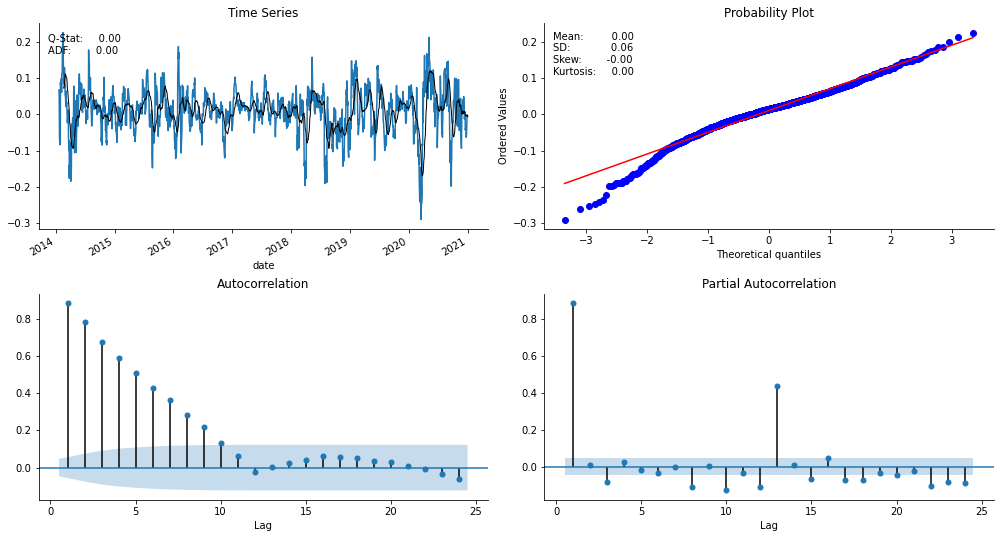

In [117]:
plot_correlogram(X_t.close, lags=24, title='Time Series')

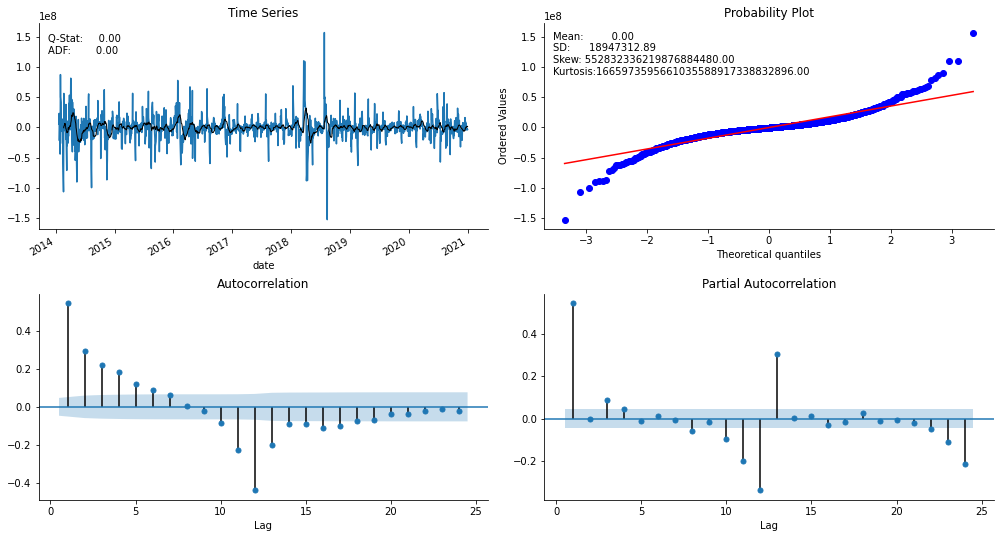

In [118]:
plot_correlogram(X_t.volume, lags=24, title="Time Series")

In [203]:
# Scaling data
X_t = X_t.apply(minmax_scale)

In [167]:
# # ARMA Summary for close and volume predictions
model = VARMAX(X_t, order=(1,1), trend='c').fit(maxiter=1000)
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['close', 'volume']   No. Observations:                 1751
Model:                      VARMA(1,1)   Log Likelihood                5312.637
                           + intercept   AIC                         -10599.274
Date:                 Fri, 03 Sep 2021   BIC                         -10528.190
Time:                         22:38:32   HQIC                        -10572.998
Sample:                              0                                         
                                - 1751                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.00, 0.09   Jarque-Bera (JB):     1813.26, 6504.76
Prob(Q):                        0.96, 0.77   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.28, 0.36   Skew:                       0.04, 0.00
Prob(H) (two-sided):        

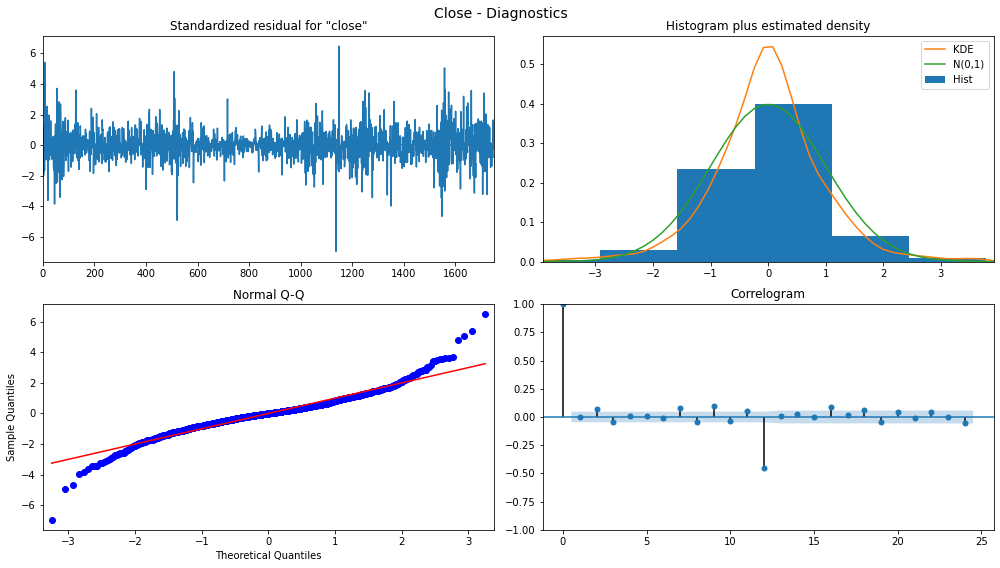

In [168]:
# Plotting diagnostics for close
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Close - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

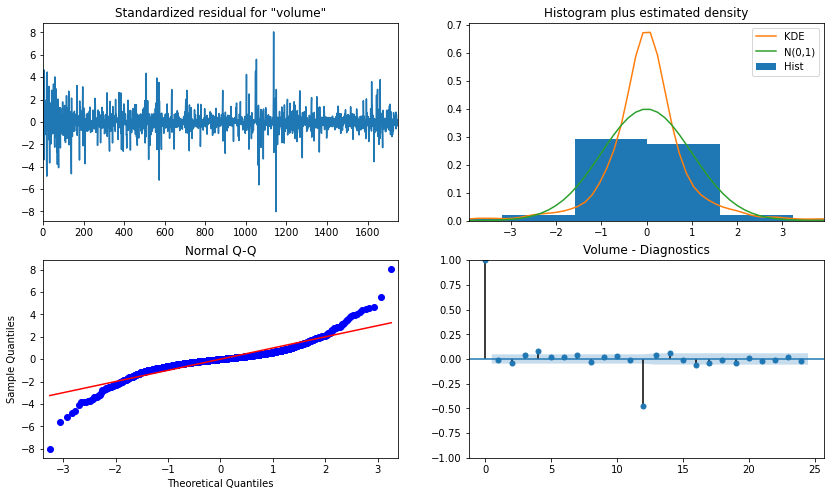

In [169]:
# Plotting diagnostics for volume
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Volume - Diagnostics');

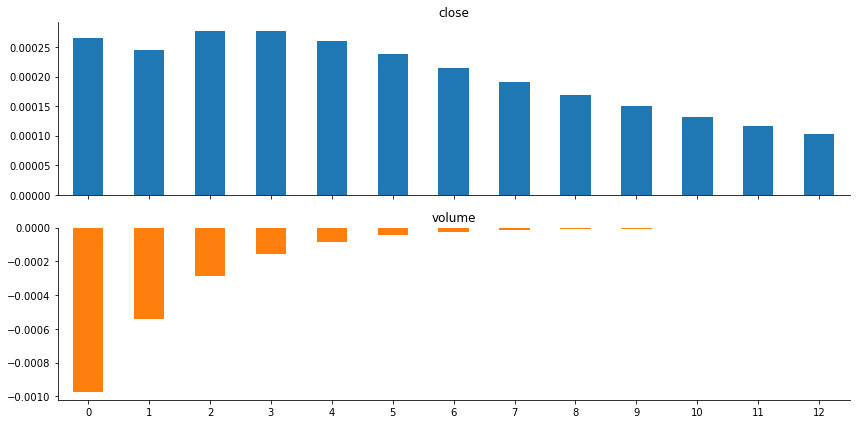

In [170]:
median_change = X_t.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,
                        impulse=median_change).plot.bar(subplots=True,
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

In [204]:
# Preparing prediction data
X_o = ohlcv.loc[symbol].loc[:, ['close', 'volume']].sort_index()
X_o = X_o.loc['2020-12-15':'2021-03-31']
X_o = pd.DataFrame({'close': np.log(X_o.close).diff(12), 'volume': (X_o.volume).diff(12)}).dropna()
X_o = X_o.apply(minmax_scale)
X_o

,close,volume
date,,
2021-01-04,0.382559,0.349844
2021-01-05,0.410828,0.407429
2021-01-06,0.313662,0.689107
2021-01-07,0.367300,0.308970
2021-01-08,0.402350,0.568265
...,...,...
2021-03-25,0.670035,0.578157
2021-03-26,0.743475,0.597345
2021-03-29,0.718931,0.526187


In [205]:
# Predicting out of sample data
n =len(X_t)
start = n

preds = model.predict(start=start+1, end=n+61)

In [207]:
# Joining predictions
preds.index = X_o.index
X_t = pd.concat([X_t, X_o], axis=0)
X_t

,close,volume
date,,
2014-01-21,0.692549,0.510865
2014-01-22,0.664460,0.567930
2014-01-23,0.542999,0.425509
2014-01-24,0.442677,0.421930
2014-01-27,0.400031,0.548949
...,...,...
2021-03-25,0.670035,0.578157
2021-03-26,0.743475,0.597345
2021-03-29,0.718931,0.526187


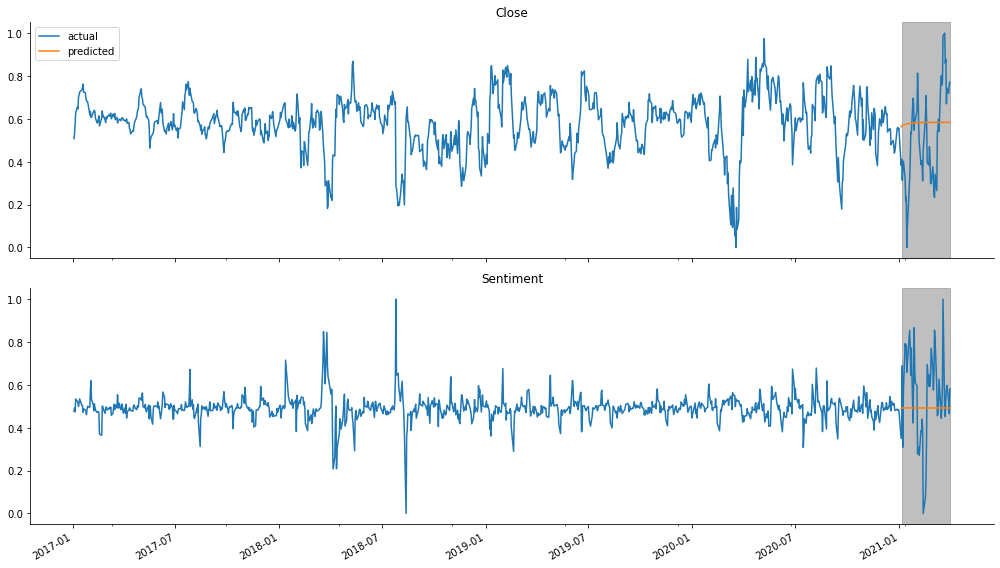

In [208]:
# Plotting out of sample predictions
preds.index = X_t.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

X_t.close.loc['2017-01-01':].plot(ax=axes[0], label='actual', title='Close')
preds.close.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=X_t.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
X_t.volume.loc['2017-01-01':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.volume.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=X_t.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();